In [1]:
import numpy as np 
import pandas as pd 
import os
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import matplotlib.pyplot as plt
import re
import random
from spacy.util import minibatch, compounding

In [2]:
df_train = pd.read_csv('drugsComTrain_raw.csv')
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


### Important words of the Corpus

In [28]:
comment_words = ' '
stopwords = set(STOPWORDS) 
for review in df_train['review']: 
    # typecaste each val to string 
    review = str(review).lower() 
    
    # split the value 
    tokens = review.split()
    comment_words = comment_words + ' '.join(tokens)

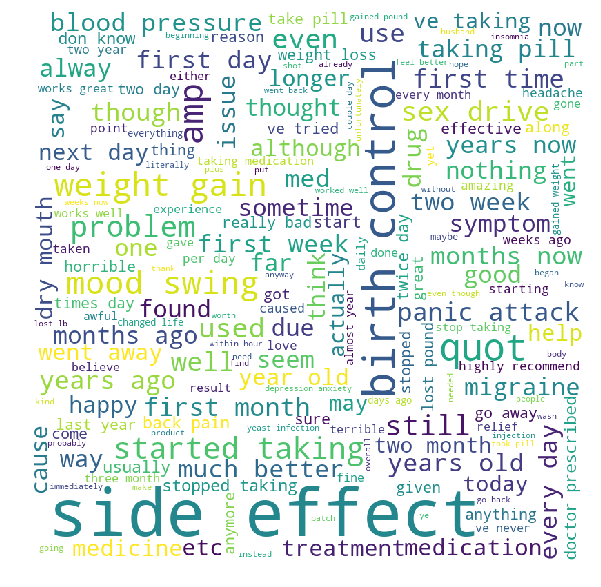

In [29]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [30]:
df_train.shape

(161297, 7)

In [31]:
drug_list = df_train['drugName'].value_counts().index.tolist()
drug_list = [x.lower() for x in drug_list]

### SpaCy recognizes the following built-in entity types:
**PERSON** - People, including fictional.

**NORP** - Nationalities or religious or political groups.

**FAC** - Buildings, airports, highways, bridges, etc.

**ORG** - Companies, agencies, institutions, etc.

**GPE** - Countries, cities, states.

**LOC** - Non-GPE locations, mountain ranges, bodies of water.

**PRODUCT** - Objects, vehicles, foods, etc. (Not services.)

**EVENT** - Named hurricanes, battles, wars, sports events, etc.

**WORK_OF_ART** - Titles of books, songs, etc.

**LAW** - Named documents made into laws.

**LANGUAGE** - Any named language.

**DATE** - Absolute or relative dates or periods.

**TIME** - Times smaller than a day.

**PERCENT** - Percentage, including "%".

**MONEY** - Monetary values, including unit.

**QUANTITY** - Measurements, as of weight or distance.

**ORDINAL** - "first", "second", etc.

**CARDINAL** - Numerals that do not fall under another type.


In [32]:
nlp = spacy.load('en_core_web_sm')
count = 0
for review in df_train['review']:
    if count < 11:
        doc = nlp(review)
        ents = [(e.text, e.label_) for e in doc.ents if e.label_ not in ('DATE', 'TIME', 'ORDINAL', 'CARDINAL')]
        print(ents)
    count += 1

[('Bystolic 5 Mg and Fish Oil', 'LAW')]
[('Intuniv', 'PERSON')]
[('US', 'GPE'), ('Lybrel', 'PERSON'), ('Lybrel', 'PERSON')]
[]
[('I&#039;m', 'GPE'), ('Suboxone', 'GPE'), ('Slight', 'ORG')]
[('Leg/ankles', 'ORG'), ('230', 'MONEY'), ('I&#039;m 50 &', 'ORG')]
[]
[('Zoloft and Clonidine', 'ORG'), ('Abilify', 'GPE'), ('Zoloft', 'ORG'), ('Clondine', 'GPE'), ('Abilify', 'LOC'), ('Abilify', 'PERSON')]
[(' ', 'NORP'), ('Keppera', 'GPE')]
[('I&#039;m', 'GPE')]
[('I&#039;m', 'NORP'), ('tons', 'QUANTITY')]


In [33]:
def process_review(review):
    processed_token = []
    for token in review.split():
        token = ''.join(e.lower() for e in token if e.isalnum())
        processed_token.append(token)
    return ' '.join(processed_token)

In [34]:
count = 0
TRAIN_DATA = []
for _, item in df_train.iterrows():
    ent_dict = {}
    if count < 1000:
        review = process_review(item['review'])
        visited_items = []
        entities = []
        for token in review.split():
            if token in drug_list:
                for i in re.finditer(token, review):
                    if token not in visited_items:
                        entity = (i.span()[0], i.span()[1], 'DRUG')
                        visited_items.append(token)
                        entities.append(entity)
        if len(entities) > 0:
            ent_dict['entities'] = entities
            train_item = (review, ent_dict)
            TRAIN_DATA.append(train_item)
            count+=1

In [39]:
n_iter = 10
iteration_nums = [] 
loss_values = []  

def train():
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    else:
        ner = nlp.get_pipe("ner")
        
    # add labels
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        loss_dict = {}  # Dictionary to store losses
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(
                texts,
                annotations,
                drop=0.5,
                losses=loss_dict
            )
        print("Losses", loss_dict)
        iteration_nums.append(itn)
        loss_values.append(loss_dict["ner"])
    

    with open("losses.txt", "w") as file:
        for i, loss in zip(iteration_nums, loss_values):
            file.write(f"Iteration: {i}, Loss: {loss}\n")
    
    return nlp


In [40]:
nlp2 = train()

Created blank 'en' model
Losses {'ner': 323.07344621601067}
Losses {'ner': 100.11745787382284}
Losses {'ner': 59.69009076131378}
Losses {'ner': 48.95163793888541}
Losses {'ner': 40.715717635784515}
Losses {'ner': 34.42023710881383}
Losses {'ner': 33.8801949794087}
Losses {'ner': 32.09948434235373}
Losses {'ner': 27.27737368283763}
Losses {'ner': 26.808553658851725}


In [41]:
#Test the model
for text, _ in TRAIN_DATA[:10]:
    doc = nlp2(text)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('phentermine', 'DRUG'), ('contrave', 'DRUG')]
Entities [('benzaclin', 'DRUG'), ('finacea', 'DRUG'), ('accutane', 'DRUG')]
Entities [('avelox', 'DRUG')]
Entities [('tamiflu', 'DRUG')]
Entities [('cipro', 'DRUG'), ('rocephin', 'DRUG')]
Entities [('actiq', 'DRUG'), ('fentanyl', 'DRUG')]
Entities [('melatonin', 'DRUG')]
Entities [('percocet', 'DRUG'), ('vicodin', 'DRUG')]
Entities [('inderal', 'DRUG')]
Entities [('contrave', 'DRUG')]


In [42]:
test_reviews = df_train.iloc[-10:, :]['review']
for review in test_reviews:
    review = process_review(review)
    print(review)
    doc = nlp2(review)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
    print('________________________')

i was super against taking medication i039ve started dealing with anxiety some depression for awhile now i got prescribed ativan months ago and never took it i thought i could handle myself again but then my relationship started to fail because of my over thinking i went back to the doctor and decided to try it she prescribed me 50 3 times a day i took a full one at night after a bad panic attack and within 30 minutes i was calm and slept through the entire night i have only been taking a half morning and mid afternoon and full at night because it does make you feel tired my brain is in a slight fog but nothing crazy i still know whats going on though  give it a try if you are suffering you will know after 1
Entities [('ativan', 'DRUG')]
________________________
i have been off prozac for about 4 weeks nowafter starting 2 years ago for a terrible depressionsadnessmenopause wanted to take a holiday to see what would happen when on prozac side effects like decrease sexual drive and sligh

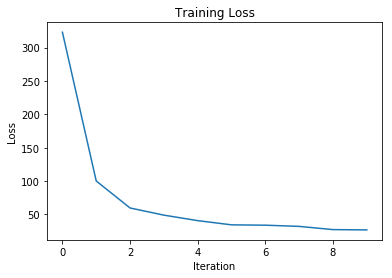

In [43]:
import matplotlib.pyplot as plt

# Read the losses from the file
iteration_nums = []
loss_values = []
with open("losses.txt", "r") as file:
    for line in file:
        parts = line.strip().split(", ")
        iteration_nums.append(int(parts[0].split(":")[1]))
        loss_values.append(float(parts[1].split(":")[1]))

# Plot the losses
plt.plot(iteration_nums, loss_values)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()